In [1]:
import statsmodels.api as sm
from scipy.stats import pearsonr, levene, stats
import pandas as pd
import numpy as np

In [2]:
df_canonical = pd.read_csv("../data/airlines_data_canonical.csv")

#Splitting the data by airline for comparison analysis
lf_aircanada = df_canonical[df_canonical['Airlines'] == 'Air Canada']["load_factor_pct"].dropna()
lf_westjet = df_canonical[df_canonical['Airlines'] == 'WestJet']["load_factor_pct"].dropna()

# Basic Averages
print("Air Canada Average Load Factor: ", lf_aircanada.mean().round(2))
print("WestJet Average Load Factor: ", lf_westjet.mean().round(2))

# Two sample T-Test to compare the two airlines
t_stat, p_value = stats.ttest_ind(lf_aircanada, lf_westjet, equal_var=False)
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a significant difference in load factors between Air Canada and WestJet")
else:
    print("No significant difference in load factors between Air Canada and WestJet")


Air Canada Average Load Factor:  83.45
WestJet Average Load Factor:  80.79
t-statistic: 4.6867, p-value: 0.0000
There is a significant difference in load factors between Air Canada and WestJet


/var/folders/gb/k6dlrgjj1sj86p2sks70tns00000gn/T/ipykernel_62559/3409653358.py:12: DeprecationWarning: Please import `ttest_ind` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  t_stat, p_value = stats.ttest_ind(lf_aircanada, lf_westjet, equal_var=False)



Business Question: Is WestJet average load factor significantly higher than Air Canada?

Load Factor (%) = how full the planes are. Higher load factor = better seat utilization = higher revenue per flight = more efficient operations. If WestJet consistently beats Air Canada here, it means they are running a leaner, more profitable network.

Take load_factor_pct for each airline, across all months. Calculate the average for Air Canada and WestJet to answer our business question. Run a t-test: a statistical test that checks if the difference in averages is real or just random noise. If p-value < 0.05, we say: “Yes, the difference in load factor is significantly different.

Why I did t-test? I see their averages are slightly different. But… is that difference just random noise (due to ups and downs in monthly data), or is it real and consistent? In plain words: it asks, “What are the chances this gap happened just by luck?”



In [3]:
# Which airline consumes more fuel per km of demand?
# Business Question: Which airline is more fuel efficient: Air Canada or WestJet?
# We’ll measure fuel litres per passenger-kilometre (lower = better efficiency).

# Fuel per passenger-km” (fuel_per_pax_km) = How many litres of fuel does the airline burn to carry one passenger for one kilometre?

df_eff = df_canonical.copy()

df_eff["fuel_max_per_km"] = np.where(
    (df_eff["pax_km"] > 0) & (~df_eff["pax_km"].isna()) & (~df_eff["fuel_litres"].isna()),
    df_eff["fuel_litres"] / df_eff["pax_km"],
    np.nan
)


fuel_eff_aircanada = df_eff[df_eff['Airlines'] == 'Air Canada']["fuel_max_per_km"].dropna()
fuel_eff_westjet = df_eff[df_eff['Airlines'] == 'WestJet']["fuel_max_per_km"].dropna()


print("Avg fuel per pax-km (Air Canada):", fuel_eff_aircanada.mean())
print("Avg fuel per pax-km (WestJet):", fuel_eff_westjet.mean())

print("\nPer 1,000,000 passenger-km:")
print("Air Canada:", (fuel_eff_aircanada.mean()*1e6).round(2), "litres per 1M pax-km")
print("WestJet:   ", (fuel_eff_westjet.mean()*1e6).round(2), "litres per 1M pax-km")
# litres of fuel needed to carry 1 passenger for 1,000,000 km. Multiplying by 1M gives a nice interpretable number.


t_stat, p_value = stats.ttest_ind(fuel_eff_aircanada, fuel_eff_westjet, equal_var=False)
print(f"\nt-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Difference is statistically significant")
else:
    print("Result: No statistically significant difference")


# Conclusion:
if (fuel_eff_aircanada.mean() > fuel_eff_westjet.mean()):
    print("\nWestJet’s average is lower, they burn fewer litres per passenger-km = more efficient.")
else:
    print("\nAir Canada’s average is lower, they burn fewer litres per passenger-km = more efficient.")



Avg fuel per pax-km (Air Canada): 0.042582082702847225
Avg fuel per pax-km (WestJet): 0.03716865683063073

Per 1,000,000 passenger-km:
Air Canada: 42582.08 litres per 1M pax-km
WestJet:    37168.66 litres per 1M pax-km

t-statistic: 14.7278, p-value: 0.0000
Difference is statistically significant

WestJet’s average is lower, they burn fewer litres per passenger-km = more efficient.


/var/folders/gb/k6dlrgjj1sj86p2sks70tns00000gn/T/ipykernel_62559/4244566582.py:29: DeprecationWarning: Please import `ttest_ind` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  t_stat, p_value = stats.ttest_ind(fuel_eff_aircanada, fuel_eff_westjet, equal_var=False)


In [4]:
def format_currency(value):
    if value >= 1e9:  # 1 billion or more
        return f"{value/1e9:,.2f} billion CAD"
    elif value >= 1e6:  # 1 million or more
        return f"{value/1e6:,.2f} million CAD"
    elif value >= 1e3:  # 1 thousand or more
        return f"{value/1e3:,.2f} thousand CAD"
    else:
        return f"{value:,.2f} CAD"

In [5]:
# If Air Canada matched WestJet’s efficiency in fuel per passenger-km, how much fuel and money could they save?


aircanada_total_paxkm = df_canonical[df_canonical["Airlines"]=="Air Canada"]["pax_km"].sum()
aircanada_total_fuel  = df_canonical[df_canonical["Airlines"]=="Air Canada"]["fuel_litres"].sum()

aircanada_fuel_if_westjet_eff = aircanada_total_paxkm * fuel_eff_westjet.mean()

fuel_price = 0.55
fuel_savings_pax = aircanada_total_fuel - aircanada_fuel_if_westjet_eff
money_savings_pax = fuel_savings_pax * fuel_price

print("\nEstimated Savings (Passenger-km efficiency):")
print("Fuel savings:", f"{fuel_savings_pax/1e6:.2f} million litres")
print("Money savings: $", format_currency(money_savings_pax))



Estimated Savings (Passenger-km efficiency):
Fuel savings: 2600.54 million litres
Money savings: $ 1.43 billion CAD


In [6]:
# Business Question 3: Which airline uses less fuel per available seat-kilometre?

# Earlier we calculated about fuel cost per traveller carried. Seat-km efficiency tells us about fuel cost per seat offered, regardless of whether the seat was filled. Lower = better efficiency.

# Fuel per seat-km = Fuel litres / seat-km


df_eff["fuel_per_seat_km"] = np.where(
    (df_eff["seat_km"] > 0) & (~df_eff["seat_km"].isna()) & (~df_eff["fuel_litres"].isna()),
    df_eff["fuel_litres"] / df_eff["seat_km"],
    np.nan
)

eff_seat_aircanada = df_eff[df_eff["Airlines"] == "Air Canada"]["fuel_per_seat_km"].dropna()
eff_seat_westjet = df_eff[df_eff["Airlines"] == "WestJet"]["fuel_per_seat_km"].dropna()

print("Avg fuel per seat-km (Air Canada):", eff_seat_aircanada.mean())
print("Avg fuel per seat-km (WestJet):", eff_seat_westjet.mean())

print("\nPer 1,000,000 seat-km:")
print("Air Canada:", (eff_seat_aircanada.mean()*1e6).round(2), "litres per 1M seat-km")
print("WestJet:   ", (eff_seat_westjet.mean()*1e6).round(2), "litres per 1M seat-km")

t_stat, p_val = stats.ttest_ind(eff_seat_aircanada, eff_seat_westjet, equal_var=False)
print("\nWelch t-stat:", round(t_stat, 2), " p-value:", round(p_val, 4))
if p_val < 0.05:
    print("Difference is statistically significant (p<0.05).")
else:
    print("No statistically significant difference (p>=0.05).")


# Conclusion:
if (eff_seat_aircanada.mean() > eff_seat_westjet.mean()):
    print("\nWestJet’s average is lower, they burn fewer litres per seat-km = more efficient.")
else:
    print("\nAir Canada’s average is lower, they burn fewer litres per seat-km = more efficient.")


Avg fuel per seat-km (Air Canada): 0.03546254419515811
Avg fuel per seat-km (WestJet): 0.0299789350341875

Per 1,000,000 seat-km:
Air Canada: 35462.54 litres per 1M seat-km
WestJet:    29978.94 litres per 1M seat-km

Welch t-stat: 31.25  p-value: 0.0
Difference is statistically significant (p<0.05).

WestJet’s average is lower, they burn fewer litres per seat-km = more efficient.


/var/folders/gb/k6dlrgjj1sj86p2sks70tns00000gn/T/ipykernel_62559/2889388198.py:24: DeprecationWarning: Please import `ttest_ind` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  t_stat, p_val = stats.ttest_ind(eff_seat_aircanada, eff_seat_westjet, equal_var=False)


In [7]:
# Interesting Question in my mind: How much money Air Canada would save if it matched WestJet’s fuel efficiency?

ac_eff = eff_seat_aircanada.mean()
wj_eff = eff_seat_westjet.mean()

aircanada_total_fuel = df_canonical[df_canonical["Airlines"]=="Air Canada"]["fuel_litres"].sum()

aircanada_total_seat_km = df_canonical[df_canonical["Airlines"]=="Air Canada"]["seat_km"].sum()

aircanada_fuel_if_westjet_efficient = eff_seat_westjet.mean() * aircanada_total_seat_km
# how much fuel Air Canada would have used if it operated as efficiently as WestJet.
# If Air Canada did the same amount of flying, but each seat-km only cost them as much fuel as WestJet spends, how much total fuel would that be

fuel_savings = aircanada_total_fuel - aircanada_fuel_if_westjet_efficient

fuel_price = 0.55
money_savings = fuel_savings * fuel_price

print("\nEstimated Savings if Air Canada matched West Jet seat-km efficiency:")
print("Fuel savings (litres):", round(fuel_savings/1e6,2), "million litres")
print("Money savings (CAD):  $", format_currency(money_savings))



Estimated Savings if Air Canada matched West Jet seat-km efficiency:
Fuel savings (litres): 3327.1 million litres
Money savings (CAD):  $ 1.83 billion CAD


In [8]:
df_reg = df_canonical.dropna().copy()

# Boolean Aircanda = 1 (Flag)
df_reg["air_canada"] = (df_reg["Airlines"]=="Air Canada").astype(int)

# Independent variables
X = df_reg[["pax_km","seat_km","hours_flown","air_canada"]]

# Dependent variable
y = df_reg["fuel_litres"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


# Here there is a problem of multicollinearity between pax_km and seat_km. Both are highly correlated with each other. So I will make 2 models separately, one with pax_km and another with seat_km. To check which affects fuel_litres more.

                            OLS Regression Results                            
Dep. Variable:            fuel_litres   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.262e+04
Date:                Mon, 01 Sep 2025   Prob (F-statistic):          7.67e-197
Time:                        14:15:44   Log-Likelihood:                -2434.1
No. Observations:                 146   AIC:                             4878.
Df Residuals:                     141   BIC:                             4893.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.295e+04   3.07e+06     -0.014      

In [9]:
# Model 1: Using pax_km

df_reg1 = df_canonical.dropna().copy()

# Boolean Aircanda = 1 (Flag)
df_reg1["air_canada"] = (df_reg1["Airlines"]=="Air Canada").astype(int)

# Independent variables
X = df_reg1[["pax_km","hours_flown","air_canada"]]

# Dependent variable
y = df_reg1["fuel_litres"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fuel_litres   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.029e+04
Date:                Mon, 01 Sep 2025   Prob (F-statistic):          5.00e-199
Time:                        14:15:44   Log-Likelihood:                -2434.3
No. Observations:                 146   AIC:                             4877.
Df Residuals:                     142   BIC:                             4889.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.118e+05   2.77e+06      0.293      

In [10]:
# Model 2: Using seat_km

df_reg2 = df_canonical.dropna().copy()

# Boolean Aircanda = 1 (Flag)
df_reg2["air_canada"] = (df_reg2["Airlines"]=="Air Canada").astype(int)

# Independent variables
X = df_reg2[["seat_km","hours_flown","air_canada"]]

# Dependent variable
y = df_reg2["fuel_litres"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fuel_litres   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.918e+04
Date:                Mon, 01 Sep 2025   Prob (F-statistic):          5.84e-185
Time:                        14:15:44   Log-Likelihood:                -2467.6
No. Observations:                 146   AIC:                             4943.
Df Residuals:                     142   BIC:                             4955.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.581e+07   3.18e+06     -4.975      

Whether you measure distance as passenger-kilometres (pax_km) or available seat-kilometres (seat_km), the slope is ~0.021–0.022 litres per km.
That means +1 billion pax_km/seat_km ≈ +21–22 million litres of fuel. Time in the air also matters a lot. Hours_flown adds roughly 1,000–1,200 litres per hour (fleet total).

When both pax_km and seat_km are in the same model, pax_km is significant and seat_km is not. Because they’re almost the same thing (both scale with flying activity), so the model can’t cleanly split their effects. So I decided to run separate models:

Seat_km-only model: seat_km has a clear, strong slope (~0.0214).
Pax_km-only model: pax_km has a clear, strong slope (~0.0217).

Conclusion: Use one of them (not both) for a clean, stable story.
If company planning is capacity optimising, use seat_km.
If company planning is demand served / revenue side, use pax_km.


The Air Canada indicator is large and positive in every model even after controlling for distance and hours:

With seat_km model: ~+53 million litres extra vs. WestJet.
With pax_km model: ~+73 million litres extra vs. WestJet.

Interpretation: Air Canada burns tens of millions more litres than WestJet. This points to a structural/operational efficiency gap.

What about the multicollinearity warning? pax_km, seat_km, and hours_flown all rise together when airlines fly more. The predictors are highly correlated, so the model flags multicollinearity. It does not break findings because the key slopes are stable and highly significant; the direction and magnitude make operational sense.

In my analysis for the case, the coefficients stay positive, reasonable, and highly significant (p < 0.001). So the findings are reliable.


In my Analysis:

1 - pax_km slope (0.0217) → fuel rises 21M litres per 1B km, holding hours and airline constant.
2 - hours_flown slope (~1055) → fuel rises ~1,055 L per flight hour, holding distance and airline constant.
3 - air_canada slope (+70M) → Air Canada uses +70M litres more fuel than WestJet, even after distance (pax_km) and hours are already accounted for.

We account for the effect of one factor while holding the others steady. Each coefficient is estimated after adjusting for the other predictors in the model. That’s what “controlling for” means — the model separates the effect of each predictor. Even after we adjust for the fact that Air Canada flies more (distance) and longer (hours), it still burns 50–70M litres extra. That gap is structural, not just volume-driven.

In [11]:
# Business Question: How closely do fuel consumption and passenger-kilometres (demand) move together over time for each airline?
# We will compute pearson correlation coefficients between fuel consumption (fuel_litres) and passenger-kilometres (pax_km) for each airline.

# Pearson's correlation when we need to determine the strength and direction of a linear relationship between two continuous quantitative variables that are also normally distributed and independent


def fuel_demand_corr(df, airline):
    subset = df[df["Airlines"] == airline].dropna(subset=["fuel_litres","pax_km"])
    corr, pval = pearsonr(subset["fuel_litres"], subset["pax_km"])
    return corr, pval

corr_aircanada, pval_aircanada = fuel_demand_corr(df_canonical, "Air Canada")
corr_westjet, pval_westjet = fuel_demand_corr(df_canonical, "WestJet")

print("Air Canada correlation fuel vs pax-km:", round(corr_aircanada, 3), "(p-value:", round(pval_aircanada,4),")")
print("WestJet correlation fuel vs pax-km:", round(corr_westjet, 3), "(p-value:", round(pval_westjet,4),")")


# Air Canada: correlation between fuel consumption and passenger-km = 0.979 (very strong)
# WestJet: correlation = 0.960 (very strong)
# Both have p < 0.001 → statistically significant (not random)

# Since the relationship is so tight, airlines can’t really save fuel just by changing how much they fly. Fuel almost always scales with demand. 

# The real move is improvement in burning less fuel per passenger-km (making each passenger-km cheaper in fuel). Now how can they do this? It's a topic for another day!
    

Air Canada correlation fuel vs pax-km: 0.979 (p-value: 0.0 )
WestJet correlation fuel vs pax-km: 0.96 (p-value: 0.0 )


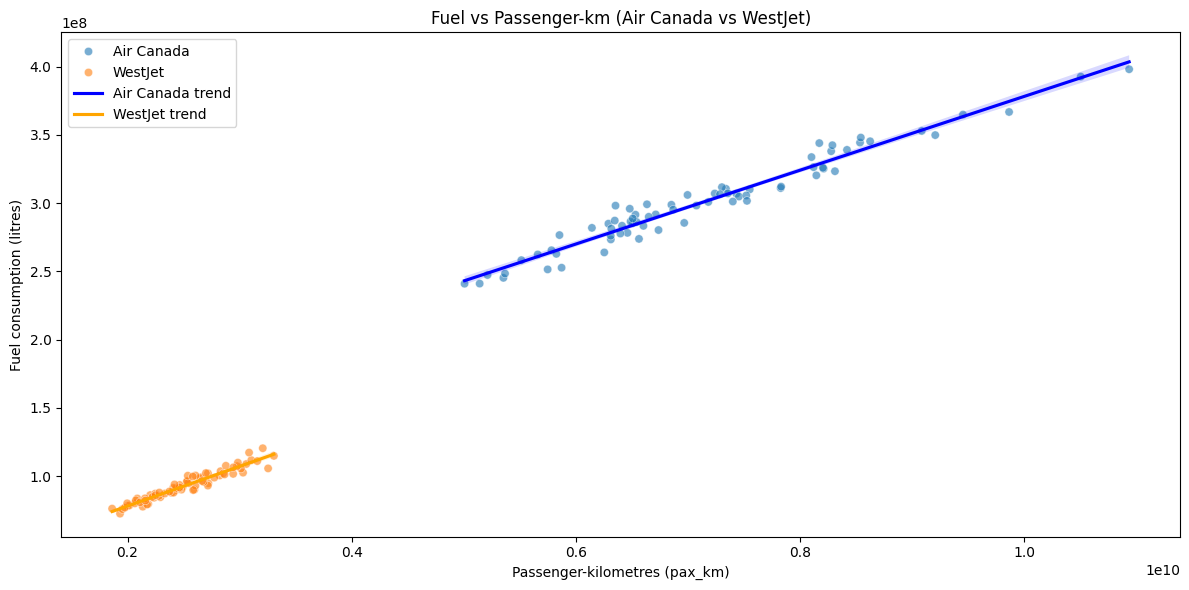

In [12]:
# Let's visualize the correlation using a scatter plot with a regression line
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.scatterplot(data=df_canonical, x="pax_km", y="fuel_litres", hue="Airlines", alpha=0.6)

sns.regplot(
    data=df_canonical[df_canonical["Airlines"]=="Air Canada"],
    x="pax_km", y="fuel_litres",
    scatter=False, color="blue", label="Air Canada trend"
)

sns.regplot(
    data=df_canonical[df_canonical["Airlines"]=="WestJet"],
    x="pax_km", y="fuel_litres",
    scatter=False, color="orange", label="WestJet trend"
)

plt.xlabel("Passenger-kilometres (pax_km)")
plt.ylabel("Fuel consumption (litres)")
plt.title("Fuel vs Passenger-km (Air Canada vs WestJet)")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# It’s true Air Canada has a larger international footprint, which makes it consume more fuel overall. But our regression model controls for both distance (pax-km) and time in the air (hours flown). Even after those adjustments, Air Canada still uses ~50–70M litres more fuel than WestJet. That shows the difference isn’t only scale or international flying, it’s an efficiency gap per unit of output.

# Both Air Canada and WestJet burn fuel almost directly in proportion to how many passengers they fly and how far. Air Canada flies at a much bigger(international) scale, and its fuel use grows very predictably with demand. WestJet also follows the same pattern but with a little more variability. To save fuel, either airline would need to make each passenger-km cheaper in fuel, not just fly more or less.

# That’s the key intuition: regression automatically adjusts for the scale of the variables you include. If one airline burns more fuel just because it flies more passenger-km (bigger scale), regression attributes that part of the fuel to the pax_km coefficient. If another airline burns more fuel just because it spends more hours in the air, regression attributes that to the hours_flown coefficient.

# What’s left over — the “extra” fuel beyond what distance and time explain — is picked up by the air_canada dummy. So instead of saying “Air Canada uses more fuel because it’s bigger,” regression says: “Let’s compare apples to apples — if both flew the same distance and time, Air Canada would still use more fuel.” That’s how it isolates the efficiency gap.

In [14]:
# Business Question: Which airline operates more consistently, who has less month-to-month volatility in efficiency and load factor?

df_eff["fuel_per_pax_km"] = df_eff["fuel_litres"] / df_eff["pax_km"]
df_eff["fuel_per_seat_km"] = df_eff["fuel_litres"] / df_eff["seat_km"]

aircanada_lf = df_eff.loc[df_eff["Airlines"]=="Air Canada", "load_factor_pct"].dropna()
westjet_lf = df_eff.loc[df_eff["Airlines"]=="WestJet",   "load_factor_pct"].dropna()

stat, p = levene(aircanada_lf, westjet_lf)
print("Load Factor variance test → p =", round(p,4))
print("Std Dev (Air Canada):", aircanada_lf.std().round(2))
print("Std Dev (WestJet):   ", westjet_lf.std().round(2))

ac_fp = df_eff.loc[df_eff["Airlines"]=="Air Canada", "fuel_per_pax_km"].dropna()
wj_fp = df_eff.loc[df_eff["Airlines"]=="WestJet",   "fuel_per_pax_km"].dropna()

stat, p = levene(ac_fp, wj_fp)
print("\nFuel per pax-km variance test → p =", round(p,4))
print("Std Dev (Air Canada):", ac_fp.std().round(6))
print("Std Dev (WestJet):   ", wj_fp.std().round(6))


# Std Dev (Air Canada): 3.44, WestJet: 3.42
#Levene p = 0.621 (>0.05) → no significant difference.

#Both airlines have similar stability in how full their planes are.Air Canada and WestJet run equally stable load factors (~3.4% variability). Neither carrier has a significant edge in consistency of seat utilization.


#Std Dev (Air Canada): 0.0027, WestJet: 0.0016
#Levene’s p = 0.000 (<0.05) → significant difference.

# WestJet’s fuel efficiency is more consistent (std dev 0.0016 vs 0.0027). Air Canada shows significantly higher volatility, meaning its per-passenger fuel burn fluctuates more across months


# WestJet is more consistent in fuel efficiency, which implies better operational control (fleet mix, route design, or scheduling). For investors or managers, WestJet looks lower risk, while Air Canada has more unpredictable fuel costs per passenger.

Load Factor variance test → p = 0.6209
Std Dev (Air Canada): 3.44
Std Dev (WestJet):    3.42

Fuel per pax-km variance test → p = 0.0
Std Dev (Air Canada): 0.002685
Std Dev (WestJet):    0.001629
